# ===========================================================
# Solve the estimation problem using supervised dataset from the Jeopardy-like logs (ONLY WITH CONTENTS)
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the convex optimization model
3. Compute train and test error

#### Last update: 04 Dec 2019

# Imports

In [2]:
from __future__ import division, print_function, absolute_import, unicode_literals

import cvxpy as cp
import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytimer import Timer

# Parameters

In [64]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data.pk'
lambdaa = 1
test_fraction = 0.2
runs = 30

# Helper functions

In [51]:
def compute_matrix_err(true_matrix: np.matrix, pred_matrix: np.matrix, type_str: str = 'frob_norm') -> float:
    if type_str == 'frob_norm':
        frob_norm_of_difference = np.linalg.norm(true_matrix - pred_matrix)
        err = frob_norm_of_difference / np.linalg.norm(true_matrix)
        return err
    elif type_str == 'corr':
#         (r, p) = sp.stats.spearmanr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        (r, p) = sp.stats.pearsonr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        if p > 0.05:
            r = 0
        return r
    else:
        raise ValueError('Wrong type_str was given.')

# Loading the data

In [52]:
data = utils.load_it(data_fpath)
print(len(data['X']))

337


In [53]:
mats = []
for i in range(len(data['y'])):
    mats.append(data['y'][i]['influence_matrix'] / 100)

In [54]:
np.mean(mats, axis=0)

array([[0.26338279, 0.24830861, 0.25548961, 0.23243323],
       [0.2189911 , 0.33845697, 0.2158457 , 0.2227003 ],
       [0.21379822, 0.2511276 , 0.30367953, 0.22474777],
       [0.25338279, 0.24091988, 0.24379822, 0.26367953]])

In [55]:
np.std(mats, axis=0)

array([[0.12754406, 0.08032826, 0.09008641, 0.07827526],
       [0.10004831, 0.19647938, 0.08964129, 0.11201212],
       [0.09734972, 0.12308318, 0.17451618, 0.10372017],
       [0.0940633 , 0.06791981, 0.06305615, 0.09161002]])

# Formulating the convex optimization problem

## Hyperparameter tuning

In [58]:
with Timer():
    lambdaas = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9, 1, 2, 5, 10, 100, 1000, 10000]
    model_errs = defaultdict(list)

    for lambdaa in lambdaas:
        print('Lambda: ', lambdaa, '...')
        for run in range(4):
            X_train, X_test, y_train, y_test = train_test_split(
                data['X'], data['y'], test_size=test_fraction)
            
            # Solving the optimization problem.
            W = cp.Variable(768, 4)
            B = cp.Variable(4, 4)

            constraints = []
            losses = 0
            for index in range(len(X_train)):
                element = X_train[index]
                influence_matrix = y_train[index]['influence_matrix'] / 100
                C = element['content_embedding_matrix']
                pred_influence_matrix = C * W + B
                loss = pred_influence_matrix - influence_matrix
                losses += cp.sum_squares(loss)
                constraints += [pred_influence_matrix >= 0]
                constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

            regluarization = cp.norm1(W) + cp.norm1(B)

            objective = cp.Minimize(losses + lambdaa * regluarization)
            prob = cp.Problem(objective, constraints)
            result = prob.solve(solver=cp.MOSEK)

        model_err = 0
        for index in range(len(X_test)):
            element = X_test[index]
            influence_matrix = y_test[index]['influence_matrix'] / 100

            # Optimization model prediction:
            C = element['content_embedding_matrix']
            predicted_influence_matrix = C * W.value + B.value

            model_err += compute_matrix_err(
                influence_matrix, predicted_influence_matrix)
            
        model_err /= len(X_test)
        model_errs[lambdaa].append(model_err)

Lambda:  0 ...
Lambda:  0.01 ...
Lambda:  0.05 ...
Lambda:  0.1 ...
Lambda:  0.2 ...
Lambda:  0.3 ...
Lambda:  0.5 ...
Lambda:  0.9 ...
Lambda:  1 ...
Lambda:  2 ...
Lambda:  5 ...
Lambda:  10 ...
Lambda:  100 ...
Lambda:  1000 ...
Lambda:  10000 ...
It took 23.24 minutes.


In [59]:
errz = []
for lambdaa in lambdaas:
    print(lambdaa, ': ', np.mean(model_errs[lambdaa]), '+-', np.std(model_errs[lambdaa]))
    errz.append(np.mean(model_errs[lambdaa]))

0 :  0.8271866339209893 +- 0.0
0.01 :  0.7850801075307889 +- 0.0
0.05 :  0.5983022266780759 +- 0.0
0.1 :  0.5385769342940921 +- 0.0
0.2 :  0.45267378529137725 +- 0.0
0.3 :  0.4298339446863062 +- 0.0
0.5 :  0.41614117793267436 +- 0.0
0.9 :  0.3761799449240127 +- 0.0
1 :  0.37044330450077384 +- 0.0
2 :  0.3548114815929205 +- 0.0
5 :  0.35259483777143585 +- 0.0
10 :  0.36065568823549926 +- 0.0
100 :  0.3547168535122731 +- 0.0
1000 :  0.36108425209498596 +- 0.0
10000 :  0.37802276268461654 +- 0.0


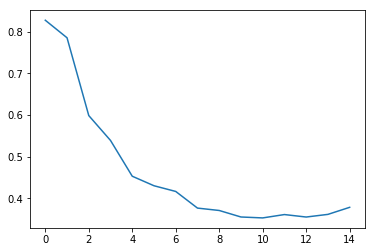

In [60]:
plt.plot(errz);

## Runs

In [65]:
lambdaa = 100

In [66]:
model_errs = []
random_errs = []
uniform_errs = []

for run in range(runs):
    print('Run', run, '...')
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=test_fraction)
    
    # Solving the optimization problem.
    with Timer():
        W = cp.Variable(768, 4)
        B = cp.Variable(4, 4)

        constraints = []
        losses = 0
        for index in range(len(X_train)):
            element = X_train[index]
            influence_matrix = y_train[index]['influence_matrix'] / 100
            C = element['content_embedding_matrix']
            pred_influence_matrix = C * W + B
            loss = pred_influence_matrix - influence_matrix
            losses += cp.sum_squares(loss)
            constraints += [pred_influence_matrix >= 0]
            constraints += [cp.sum_entries(pred_influence_matrix, axis=1) == 1]

        regluarization = cp.norm1(W) + cp.norm1(B)

        objective = cp.Minimize(losses + lambdaa * regluarization)
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver=cp.MOSEK)
        print('It was {} and result was {}'.format(prob.status, result))

    model_err = 0
    random_err = 0
    uniform_err = 0
    for index in range(len(X_test)):
        element = X_test[index]
        influence_matrix = y_test[index]['influence_matrix'] / 100
        
        # Random model prediction:
        pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
            np.random.rand(4, 4)))
        random_err += compute_matrix_err(
            influence_matrix, pred_random_influence_matrix)
        
        # Uniform prediction:
        pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
        uniform_err += compute_matrix_err(
            influence_matrix, pred_uniform_influence_matrix)
        
        # Optimization model prediction:
        C = element['content_embedding_matrix']
        predicted_influence_matrix = C * W.value + B.value

        model_err += compute_matrix_err(
            influence_matrix, predicted_influence_matrix)
    #     err += frob_norm_of_difference
    model_err /= len(X_test)
    random_err /= len(X_test)
    uniform_err /= len(X_test)

    model_errs.append(model_err)
    random_errs.append(random_err)
    uniform_errs.append(uniform_err)

Run 0 ...
It was optimal and result was 451.0076266644446
It took 17.54 seconds.
Run 1 ...
It was optimal and result was 452.0530369075709
It took 16.65 seconds.
Run 2 ...
It was optimal and result was 452.6478347188248
It took 17.48 seconds.
Run 3 ...
It was optimal and result was 453.0588971013281
It took 17.01 seconds.
Run 4 ...
It was optimal and result was 452.35257028818853
It took 17.29 seconds.
Run 5 ...
It was optimal and result was 453.50017087040135
It took 16.63 seconds.
Run 6 ...
It was optimal and result was 453.5624950460066
It took 17.23 seconds.
Run 7 ...
It was optimal and result was 453.8213089517982
It took 17.31 seconds.
Run 8 ...
It was optimal and result was 449.5863987775196
It took 17.02 seconds.
Run 9 ...
It was optimal and result was 453.02481453023165
It took 17.41 seconds.
Run 10 ...
It was optimal and result was 454.2242031581379
It took 17.28 seconds.
Run 11 ...
It was optimal and result was 451.74996773595865
It took 17.54 seconds.
Run 12 ...
It was opti

random: 0.6344122315859531 +- 0.01840255448912705
uniform: 0.3452197479415015 +- 0.01875661696853107
model: 0.348088690284147 +- 0.015648935278394865


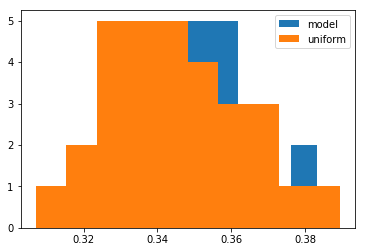

In [67]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));